# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

Learning Standard Hopf Bifurcation 

In [126]:
from torchdiffeq import odeint as odeint

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [340]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.system_dim = 2


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)
    
    def na_f(self, t, x):
        xdot = x[:, 2] * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + x[:, 2] * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)

        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1), torch.zeros_like(xdot).unsqueeze(1)], dim = 1)


In [341]:
lc = Hopf(rho=1.0, alpha=-1.0, beta=0.0)
#Supercritical hopf 

In [342]:
y0 = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [0.0, 0.0, 1.0]])
y0.shape

torch.Size([3, 3])

In [343]:
lc.na_f(t = 0, x = y0).shape

torch.Size([3, 3])

In [344]:
sol = odeint(func=lc.na_f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

In [365]:
a = torch.arange(-2.0, 2.0, 0.5); b = torch.arange(-2, 2, 0.5); c = torch.ones_like(a)
ic = torch.cartesian_prod(a, b, torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))  #traj, dim


t_span = (0, 10); dt = 0.05
ic.shape #traj, dim


torch.Size([320, 3])

In [346]:
lc.f = lc.na_f

In [366]:
sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )


In [348]:
sol.shape

torch.Size([200, 320, 3])

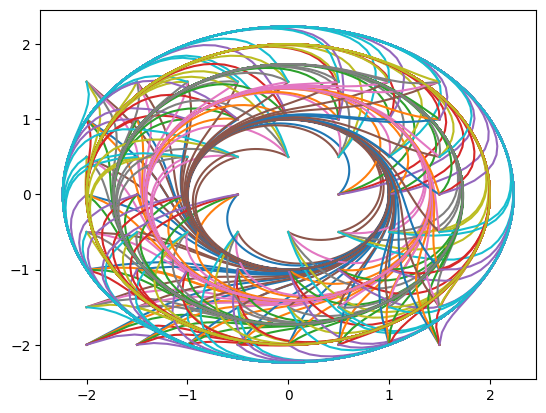

In [349]:
for i in range(ic.shape[0]):
    plt.plot(sol[:, i, 0], sol[:, i, 1])

In [350]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

In [351]:
print(training_data_tensor.shape, t_eval_tensor.shape)

torch.Size([1, 200, 320, 3]) torch.Size([1, 200])


# Neural ODE - 

In [352]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [353]:
model = NODE(input_dim=lc.system_dim+1, output_dim=lc.system_dim+1, depth=5, width=20, activation_func=nn.Tanh())  

In [354]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [355]:
num_epochs = 500
batch_size = 32
num_batches = 10

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 1/500 [00:00<07:42,  1.08it/s]

Epoch 0, Loss: 2.3051347732543945


  4%|▍         | 21/500 [00:20<10:46,  1.35s/it]

Epoch 20, Loss: 1.2676321268081665


  8%|▊         | 41/500 [00:49<10:40,  1.39s/it]

Epoch 40, Loss: 1.063847541809082


 12%|█▏        | 61/500 [01:17<10:12,  1.40s/it]

Epoch 60, Loss: 0.9744133949279785


 16%|█▌        | 81/500 [01:45<09:50,  1.41s/it]

Epoch 80, Loss: 0.9125998616218567


 20%|██        | 101/500 [02:13<09:24,  1.42s/it]

Epoch 100, Loss: 0.8472392559051514


 24%|██▍       | 121/500 [02:42<10:02,  1.59s/it]

Epoch 120, Loss: 0.670468807220459


 28%|██▊       | 141/500 [03:09<08:13,  1.38s/it]

Epoch 140, Loss: 0.5201181769371033


 32%|███▏      | 161/500 [03:36<07:35,  1.34s/it]

Epoch 160, Loss: 0.44742119312286377


 36%|███▌      | 181/500 [03:56<04:10,  1.27it/s]

Epoch 180, Loss: 0.37675613164901733


 40%|████      | 201/500 [04:23<07:04,  1.42s/it]

Epoch 200, Loss: 0.30655884742736816


 44%|████▍     | 221/500 [04:51<06:34,  1.41s/it]

Epoch 220, Loss: 0.23994113504886627


 48%|████▊     | 241/500 [05:20<06:11,  1.44s/it]

Epoch 240, Loss: 0.17721550166606903


 52%|█████▏    | 261/500 [05:49<05:42,  1.43s/it]

Epoch 260, Loss: 0.1189248263835907


 56%|█████▌    | 281/500 [06:18<05:06,  1.40s/it]

Epoch 280, Loss: 0.07775992155075073


 60%|██████    | 301/500 [06:46<04:35,  1.39s/it]

Epoch 300, Loss: 0.05812607333064079


 64%|██████▍   | 321/500 [07:14<04:12,  1.41s/it]

Epoch 320, Loss: 0.048758890479803085


 68%|██████▊   | 341/500 [07:42<03:50,  1.45s/it]

Epoch 340, Loss: 0.042910508811473846


 72%|███████▏  | 361/500 [08:10<03:28,  1.50s/it]

Epoch 360, Loss: 0.03881383687257767


 76%|███████▌  | 381/500 [08:40<02:50,  1.43s/it]

Epoch 380, Loss: 0.03583566099405289


 80%|████████  | 401/500 [09:10<02:28,  1.50s/it]

Epoch 400, Loss: 0.03360665217041969


 84%|████████▍ | 421/500 [09:39<01:58,  1.50s/it]

Epoch 420, Loss: 0.03186966851353645


 88%|████████▊ | 441/500 [10:08<01:24,  1.44s/it]

Epoch 440, Loss: 0.030452873557806015


 92%|█████████▏| 461/500 [10:36<00:57,  1.47s/it]

Epoch 460, Loss: 0.029250571504235268


 96%|█████████▌| 481/500 [11:05<00:26,  1.42s/it]

Epoch 480, Loss: 0.028201840817928314


100%|██████████| 500/500 [11:33<00:00,  1.39s/it]


In [112]:
# Analysis of Trained Model

Text(0.5, 0, 'Epochs')

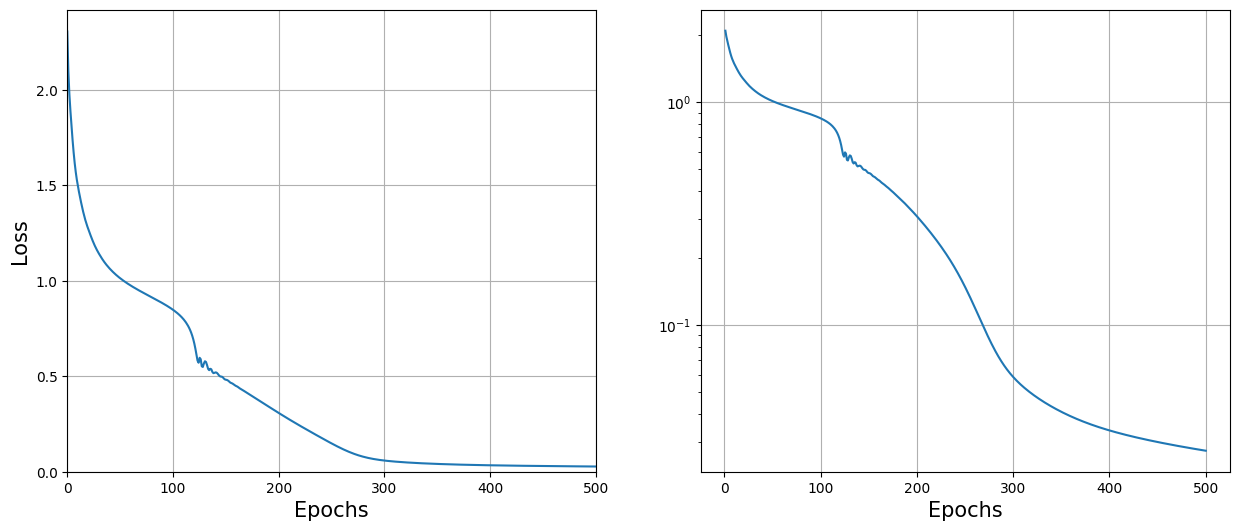

In [356]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [367]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

r_vals.shape

torch.Size([110])

In [368]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)

t_Start_pred = 0; t_Final_pred = 10; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(model, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

In [369]:
true_data.shape

torch.Size([200, 11000, 3])

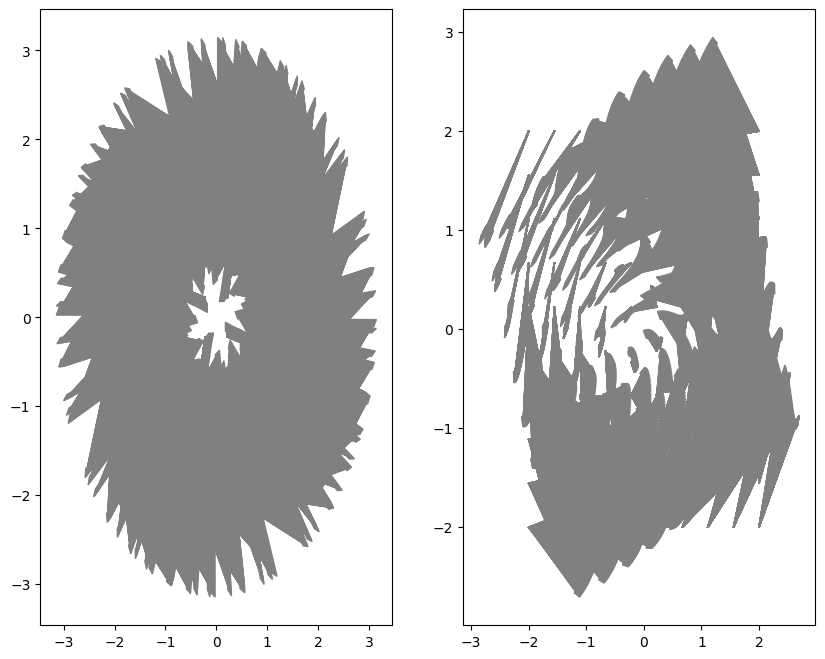

In [370]:
#Plotting results
fig = plt.figure(figsize=(10, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1)
for i in range(pts.shape[0]):
    ax1.arrow(x=true_data[0, i, 0].detach().numpy(), y=true_data[0, i, 1].detach().numpy(), 
          dx=true_data[10, i, 0].detach().numpy() - true_data[0, i, 0].detach().numpy(), 
          dy=true_data[10, i, 1].detach().numpy() - true_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')


#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2)
for i in range(pts.shape[0]):
    ax2.arrow(x=node_data[0, i, 0].detach().numpy(), y=node_data[0, i, 1].detach().numpy(), 
          dx=node_data[10, i, 0].detach().numpy() - node_data[0, i, 0].detach().numpy(), 
          dy=node_data[10, i, 1].detach().numpy() - node_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')

    



plt.show()

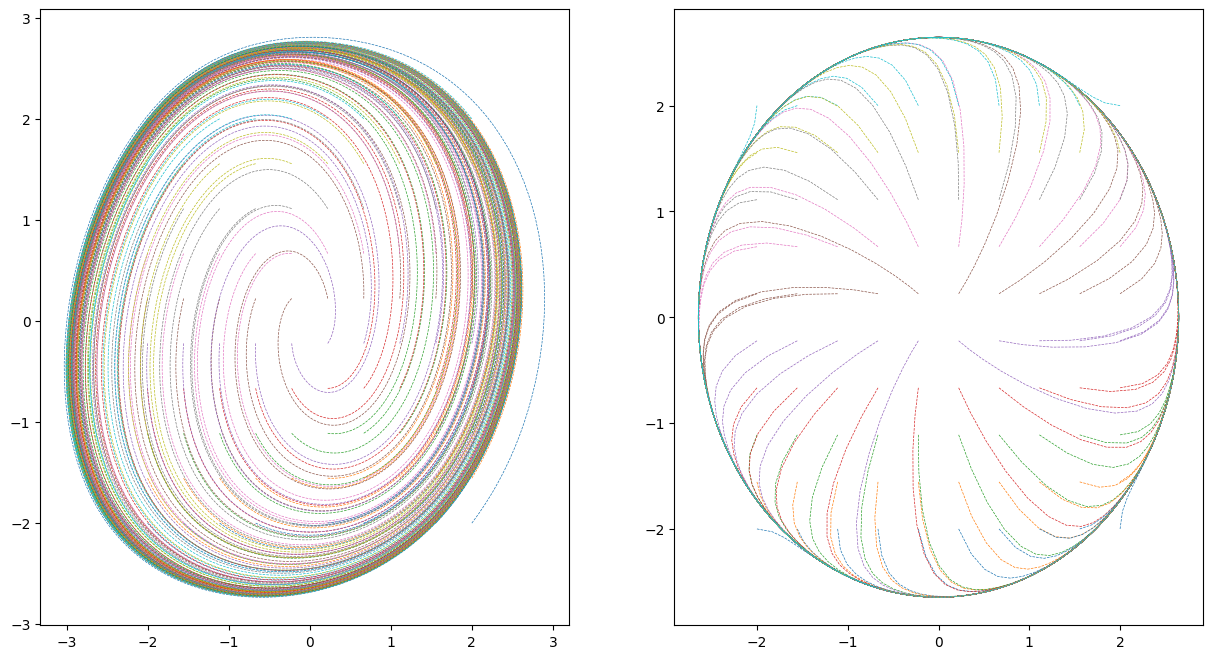

In [381]:
fig = plt.figure(figsize=(15, 8))
r = 7
#First Plot
print()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(), node_data[:, pts[:, 2] == r, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(), true_data[:, pts[:, 2] == r, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

In [372]:
pts.shape

torch.Size([11000, 3])

In [363]:
# Interactive trajectory plot
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def plot_traj(idx=0):
    fig = plt.figure(figsize=(15, 8))
    r_val = r_vals[idx]
    print('rho = ', r_val.float())
    #First Plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(node_data[:, pts[:, 2] == r_val, 0].detach().numpy(), node_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(true_data[:, pts[:, 2] == r_val, 0].detach().numpy(), true_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')


In [ ]:
interact(plot_traj, idx=IntSlider(min=0.0, max=r_vals.shape[0]-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=109), Output()), _dom_classes=('widget-interac…

<function __main__.plot_traj(idx=0)>